In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, RepeatVector, Flatten
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import keras_tuner as kt
import os
import yfinance as yf

In [3]:
# Helper Function to fetch historical stock data
def get_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"

ticker_symbol = "BNII.JK"  # Example ticker for stock data
start_date = "2010-01-01"
end_date = "2024-10-01"
stock_data = get_stock_data(ticker_symbol, start_date, end_date)
stock_data.asfreq('B').index  # Set index frequency to business daily
stock_data.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3638 entries, 2010-01-04 to 2024-09-30
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BNII.JK)  3638 non-null   float64
 1   (Close, BNII.JK)      3638 non-null   float64
 2   (High, BNII.JK)       3638 non-null   float64
 3   (Low, BNII.JK)        3638 non-null   float64
 4   (Open, BNII.JK)       3638 non-null   float64
 5   (Volume, BNII.JK)     3638 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 328.0 KB


In [4]:
# Prepare Data for LSTM
df = stock_data.copy()

# Use the 'Close' price directly (no wavelet transform)
close_prices = df['Close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Hyperparameter tuning model definition
def build_model(units, dropout):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units, return_sequences=True, input_shape=(seq_length, 1))))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units // 2, return_sequences=False)))  # Adjust units for second LSTM layer
    model.add(Dropout(dropout))
    model.add(RepeatVector(seq_length))
    model.add(Dropout(0.2))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32))
    model.add(Flatten())
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Initialize the Hyperparameter Tuner with RandomSearch
tuner = kt.RandomSearch(build_model, 
                        objective='val_loss', 
                        max_trials=2,  # Limit to 2 trials
                        directory='kt_dir', 
                        project_name='stock_tuning')

# Create TensorBoard log directory
log_dir = "logs/fit"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Setup TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start the hyperparameter tuning
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[tensorboard_callback, early_stopping])

# Get the best hyperparameters
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hp = best_trial.hyperparameters.values

print("Best Hyperparameters:", best_hp)

# Train the model with best hyperparameters
best_model = build_model(units=best_hp['units'], dropout=best_hp['dropout'])  # Pass the raw values directly
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[tensorboard_callback, early_stopping])

# Make predictions
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Optionally print the error metrics
print(f"Train MAE: {train_mae}, Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train MAPE: {train_mape}, Train R2: {train_r2}")
print(f"Test MAE: {test_mae}, Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAPE: {test_mape}, Test R2: {test_r2}")


Reloading Tuner from kt_dir\stock_tuning\tuner0.json
Best Hyperparameters: {'units': 192, 'dropout': 0.30000000000000004, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0107 - mae: 0.0608 - val_loss: 1.0313e-04 - val_mae: 0.0069
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0011 - mae: 0.0214 - val_loss: 1.6121e-04 - val_mae: 0.0100
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0011 - mae: 0.0204 - val_loss: 2.2663e-04 - val_mae: 0.0128
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 6.5460e-04 - mae: 0.0169 - val_loss: 1.0673e-04 - val_mae: 0.0081
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5.5288e-04 - mae: 0.0154 - val_loss: 1.2459e-04 - val_mae: 0.0091
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 5.3004e-04 - mae: 0.0157 - val_loss: 1.6539e-04 - val_mae: 0.0111
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/ste

In [5]:
metric_data = {
    "Metric": ["MAE", "MSE", "RMSE", "MAPE", "R2"],
    "Train": [train_mae, train_mse, train_rmse, train_mape, train_r2],
    "Test": [test_mae, test_mse, test_rmse, test_mape, test_r2]
}

# Convert to dataframe
metric_df = pd.DataFrame(metric_data)

print(metric_df)



  Metric       Train       Test
0    MAE    7.844603   3.729441
1    MSE  192.372394  31.533763
2   RMSE   13.869838   5.615493
3   MAPE    0.029375   0.014245
4     R2    0.985594   0.978071


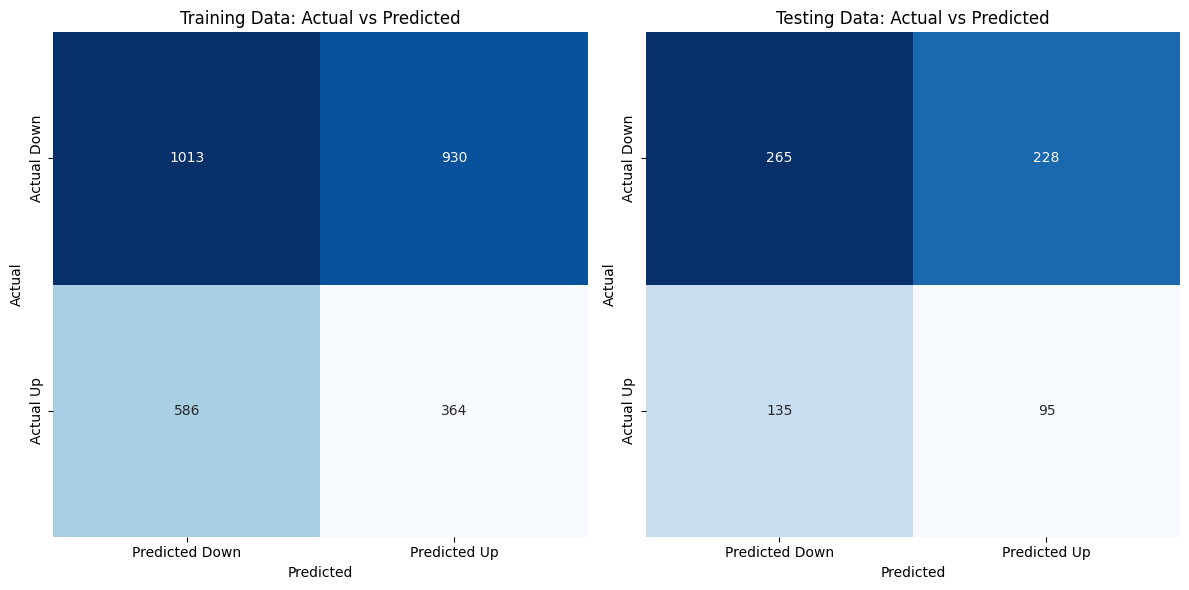

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to calculate direction (up = 1, down = 0)
def calculate_direction(prices):
    return [1 if prices[i] > prices[i - 1] else 0 for i in range(1, len(prices))]

# Get the direction of actual and predicted prices
train_actual_direction = calculate_direction(y_train)
train_predicted_direction = calculate_direction(train_predictions)

test_actual_direction = calculate_direction(y_test)
test_predicted_direction = calculate_direction(test_predictions)

# Confusion matrix for training data
train_cm = confusion_matrix(train_actual_direction, train_predicted_direction)

# Confusion matrix for testing data
test_cm = confusion_matrix(test_actual_direction, test_predicted_direction)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Down', 'Predicted Up'], 
                yticklabels=['Actual Down', 'Actual Up'], cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Plot confusion matrix for training and testing data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_confusion_matrix(train_cm, 'Training Data: Actual vs Predicted', ax[0])
plot_confusion_matrix(test_cm, 'Testing Data: Actual vs Predicted', ax[1])

plt.tight_layout()
plt.show()


Expected train index length: 2894, Actual y_train length: 2894


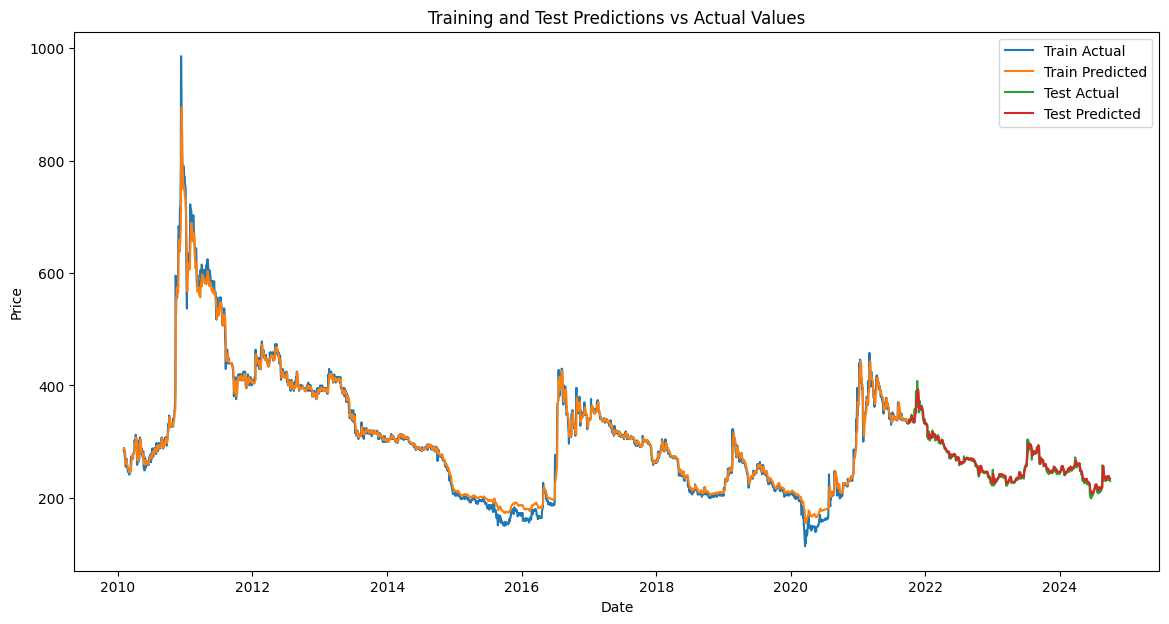

In [6]:
import matplotlib.pyplot as plt

# Ensure y_train is flattened (1D array) if it's 2D
y_train = y_train.flatten()
train_predictions = train_predictions.flatten()

# Check the expected slice lengths
train_index_length = len(df.index[seq_length:split + seq_length])
print(f"Expected train index length: {train_index_length}, Actual y_train length: {len(y_train)}")

# Make sure y_train length matches the slice length for the train data
y_train_sliced = y_train[:train_index_length]
train_predictions_sliced = train_predictions[:train_index_length]

# Visualize the results
plt.figure(figsize=(14, 7))

# Train actual vs predicted
plt.plot(df.index[seq_length:split + seq_length], y_train_sliced, label='Train Actual')
plt.plot(df.index[seq_length:split + seq_length], train_predictions_sliced, label='Train Predicted')

# Test actual vs predicted
test_index = df.index[split + seq_length:]  # Get the proper test index range
y_test_sliced = y_test.flatten()[:len(test_index)]  # Slice y_test to match test_index
test_predictions_sliced = test_predictions.flatten()[:len(test_index)]  # Slice test_predictions to match test_index

plt.plot(test_index, y_test_sliced, label='Test Actual')
plt.plot(test_index, test_predictions_sliced, label='Test Predicted')

# Add legend and labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Training and Test Predictions vs Actual Values')

# Save the figure
plt.savefig('LSTM.jpg')
# Optionally display the plot
plt.show()


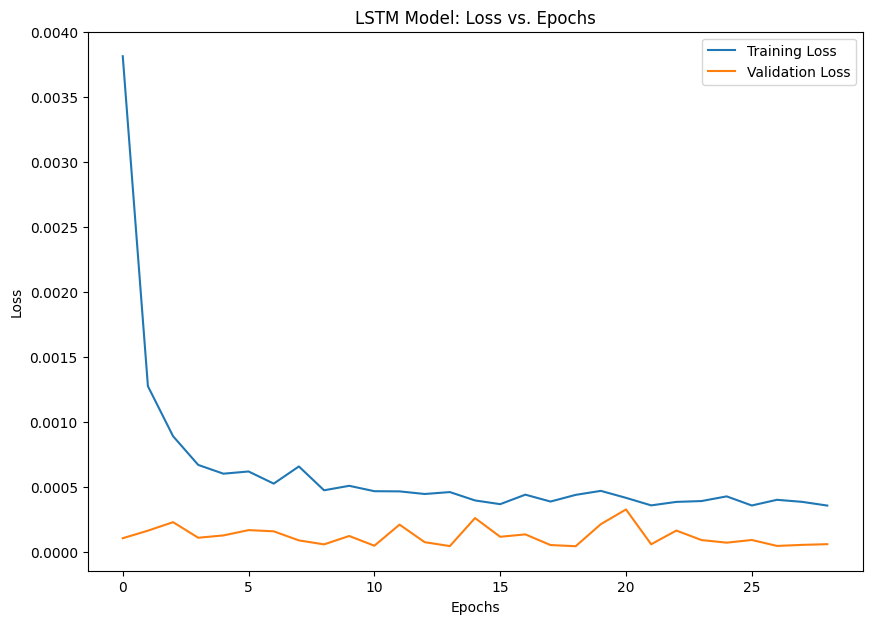

In [7]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
# If you have validation loss, you can plot it as well
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model: Loss vs. Epochs')
plt.legend()

#plt.show()

# Save the figure
plt.savefig('LossEpoch.jpg')

In [8]:
import pandas as pd
df_index = pd.DataFrame(stock_data['Close'].iloc[-y_test.shape[0]:].copy()).index
# Suppose y_test and predict_value are NumPy arrays
y_test_df = pd.DataFrame(y_test, columns=['y_test'], index=df_index )
predict_value_df = pd.DataFrame(test_predictions, columns=['predict_value'], index=df_index)

# Concatenate along the columns
combined_df = pd.concat([y_test_df, predict_value_df], axis=1)
combined_df

,y_test,predict_value
Date,,
2021-10-01,334.0,332.920013
2021-10-04,336.0,333.345825
2021-10-05,340.0,334.579773
2021-10-06,338.0,337.179016
2021-10-07,334.0,338.085602
...,...,...
2024-09-24,236.0,237.529724
2024-09-25,232.0,237.658813
2024-09-26,232.0,236.175797


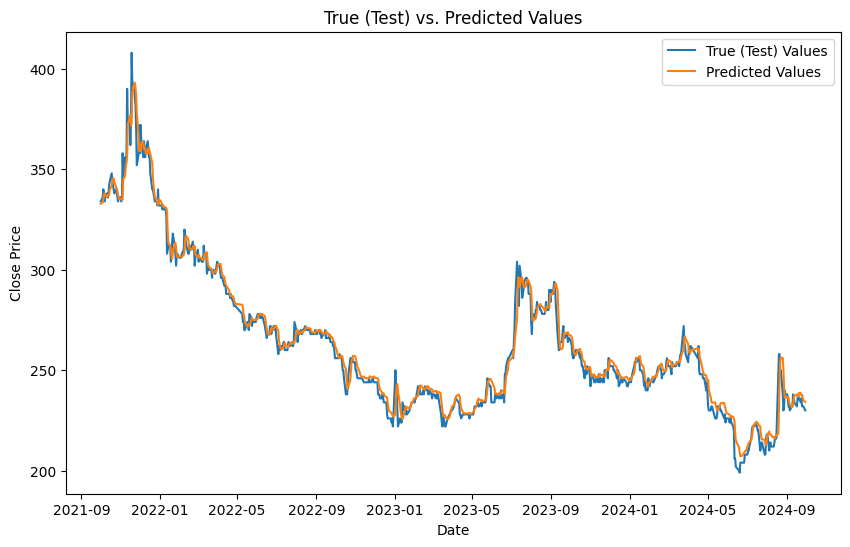

In [9]:
# Plotting true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(combined_df.index, combined_df['y_test'], label='True (Test) Values')
plt.plot(combined_df.index, combined_df['predict_value'], label='Predicted Values')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('True (Test) vs. Predicted Values')
plt.legend()
#plt.show()

# Save the figure
plt.savefig('LSTM2.jpg')

In [10]:

input_seq = X_test[-seq_length:]  # Use same window size as used in training
#print(input_seq.shape)

next_n_days_predictions = []

# Forecast for the next n days
forecast_horizon = 10


for _ in range(forecast_horizon):
     # Reshape the input to match the model's expected input shape
    input_seq = input_seq.reshape((1, -seq_length, 1))  # Shape should be (1, window_size, 1)

    # Predict the next value
    predicted_value = best_model.predict(input_seq)

    # Append prediction to results
    next_n_days_predictions.append(predicted_value[0, 0])
    
    # Update the input window with the new prediction
    #input_seq = np.append(input_seq, predicted_value)
    # Update the historical_data sequence by removing the oldest value and adding the predicted value
    input_seq = np.roll(input_seq, shift=-1)
    input_seq[-1] = predicted_value

next_n_days_predictions = scaler.inverse_transform(np.array(next_n_days_predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


In [11]:
import pandas_market_calendars as mcal
last_date = df.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

# Get US holidays for the NYSE calendar 
nyse = mcal.get_calendar('NYSE') 
us_holidays = nyse.valid_days(start_date=prediction_dates[0], end_date=prediction_dates[-1])

# Filter out holidays 
filtered_dates = prediction_dates[~prediction_dates.isin(us_holidays)]

predictions_df = pd.DataFrame(next_n_days_predictions, columns=['Predictions'], index=filtered_dates)
predictions_df

,Predictions
2024-10-01,232.847061
2024-10-02,234.295502
2024-10-03,235.737534
2024-10-04,237.217484
2024-10-07,238.733368
2024-10-08,240.231369
2024-10-09,241.710831
2024-10-10,243.171371
2024-10-11,244.612396
2024-10-14,246.033447


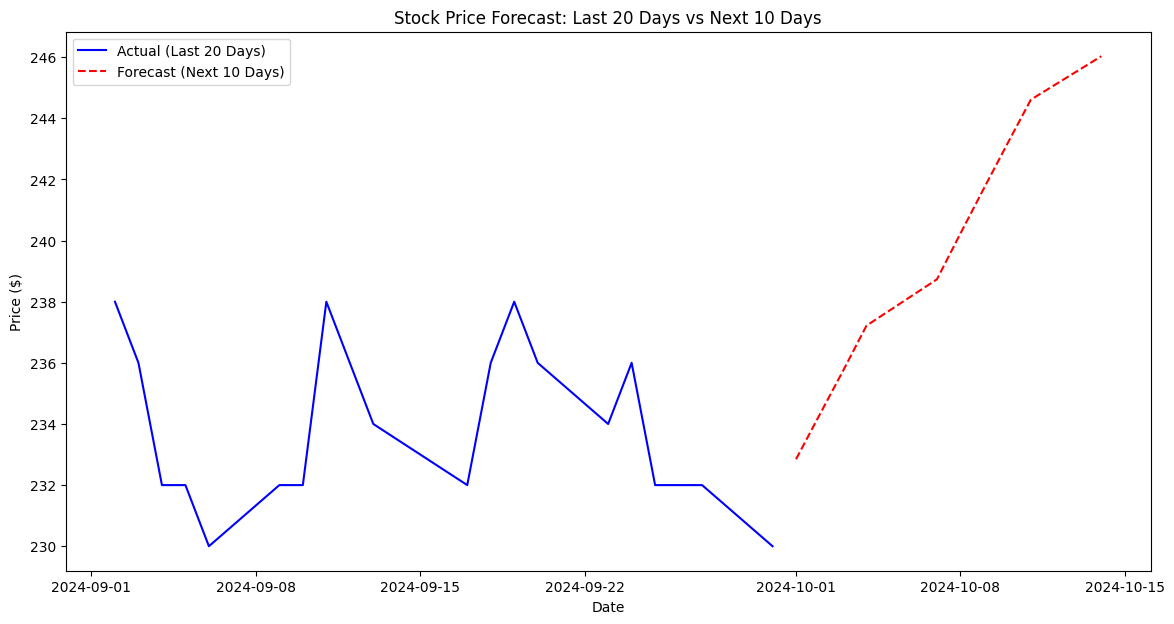

In [12]:
# Select the last 10 actual data points from the historical data
last_20_actual_dates = df.index[-20:]
last_20_actual_values = df['Close'].values[-20:]

# Plot the actual data and the forecasted data
plt.figure(figsize=(14, 7))

# Plot last 10 actual values
plt.plot(last_20_actual_dates, last_20_actual_values, label='Actual (Last 20 Days)', color='blue')

# Plot the predicted values for the next 10 days
plt.plot(predictions_df.index, predictions_df['Predictions'], label='Forecast (Next 10 Days)', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Stock Price Forecast: Last 20 Days vs Next 10 Days')
plt.legend()

# Save the figure as a .jpg file
plt.savefig('Stock_Price_Forecast.jpg')

# Optionally, display the plot
plt.show()